# Time Series Clustering

## 0. 데이터 불러오기

In [ ]:
!pip install tslearn

     |████████████████████████████████| 798kB 5.1MB/s 


In [ ]:
import numpy as np
import pandas as pd
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='MalgunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [ ]:
data = pd.read_csv('data.csv', encoding='CP949')

In [ ]:
data = data[data['big_cat']=='냉난방가전'].reset_index(drop=True)

In [ ]:
data.shape

(129227, 7)

In [ ]:
data.head(2)

,date,sex,age,big_cat,sm_cat,qty,cnt
0,20180101,F,20,냉난방가전,가열식 가습기,1,1.7408
1,20180101,F,40,냉난방가전,가열식 가습기,3,1.7408


# 2. 데이터 전처리

## 2-1. 2018년, 2019년 요일 맞추기

In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
data['year'] = data['date'].dt.year
buy_2018 = data[data.year==2018][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = data[data.year==2019][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2018.shape, buy_2019.shape

((63020, 6), (66207, 6))

In [ ]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

In [ ]:
buy_2018_cat = buy_2018.groupby(['date', 'sm_cat']).sum('qty').reset_index()[['date', 'sm_cat', 'qty']]
buy_2019_cat = buy_2019.groupby(['date', 'sm_cat']).sum('qty').reset_index()[['date', 'sm_cat', 'qty']]
buy_2018_cat["date"] = buy_2018_cat["date"].progress_apply(lambda x : str(x)[5:10])
buy_2019_cat["date"] = buy_2019_cat["date"].progress_apply(lambda x : str(x)[5:10])
buy_2018_ts = pd.pivot_table(buy_2018_cat, index="sm_cat", columns="date", values="qty")
buy_2019_ts = pd.pivot_table(buy_2019_cat, index="sm_cat", columns="date", values="qty")
buy_2018_ts.shape, buy_2019_ts.shape

((40, 365), (40, 365))

## 2-2. 결측값

In [ ]:
buy_2018_ts = buy_2018_ts.fillna(0)
buy_2019_ts = buy_2019_ts.fillna(0)

## 2-3. 정규화

In [ ]:
avg_lst = []; std_lst = []
for idx, row in tqdm(buy_2018_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

In [ ]:
buy_2018_ts['avg'] = avg_lst
buy_2018_ts['std'] = std_lst
buy_2018_ts.head(2)

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,avg,std
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가스온수기,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156164,0.445054
가열식 가습기,23.0,12.0,15.0,18.0,11.0,17.0,15.0,16.0,16.0,15.0,10.0,9.0,5.0,7.0,9.0,6.0,4.0,6.0,4.0,4.0,7.0,9.0,11.0,15.0,14.0,3.0,10.0,18.0,15.0,10.0,6.0,6.0,4.0,7.0,9.0,6.0,5.0,7.0,10.0,5.0,...,19.0,18.0,23.0,26.0,20.0,14.0,6.0,8.0,21.0,19.0,19.0,24.0,13.0,14.0,23.0,30.0,35.0,30.0,30.0,26.0,22.0,16.0,27.0,27.0,16.0,15.0,19.0,8.0,11.0,15.0,15.0,21.0,14.0,32.0,15.0,23.0,16.0,7.0,5.734247,7.298054


In [ ]:
for i in tqdm(range(len(buy_2018_ts))):
    for j in range(365):
        buy_2018_ts.iloc[i,j] = (buy_2018_ts.iloc[i,j] - buy_2018_ts.iloc[i,365])/buy_2018_ts.iloc[i,366]

In [ ]:
buy_2018_ts = buy_2018_ts.drop(['avg','std'], axis=1)

In [ ]:
avg_lst = []; std_lst = []
for idx, row in tqdm(buy_2019_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

In [ ]:
buy_2019_ts['avg'] = avg_lst
buy_2019_ts['std'] = std_lst
buy_2019_ts.head(2)

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,avg,std
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가스온수기,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.257534,0.564012
가열식 가습기,26.0,27.0,27.0,20.0,12.0,17.0,18.0,21.0,27.0,15.0,12.0,11.0,13.0,13.0,15.0,10.0,13.0,10.0,5.0,10.0,7.0,10.0,12.0,6.0,8.0,5.0,6.0,11.0,9.0,10.0,9.0,5.0,3.0,3.0,0.0,1.0,5.0,9.0,8.0,3.0,...,13.0,30.0,18.0,27.0,18.0,20.0,23.0,16.0,30.0,45.0,34.0,37.0,85.0,34.0,29.0,50.0,37.0,31.0,25.0,21.0,9.0,21.0,32.0,10.0,20.0,34.0,20.0,16.0,27.0,29.0,19.0,10.0,20.0,19.0,14.0,7.0,18.0,15.0,7.830137,10.666970


In [ ]:
for i in tqdm(range(len(buy_2019_ts))):
    for j in range(365):
        buy_2019_ts.iloc[i,j] = (buy_2019_ts.iloc[i,j] - buy_2019_ts.iloc[i,365])/buy_2019_ts.iloc[i,366]

In [ ]:
buy_2019_ts = buy_2019_ts.drop(['avg','std'], axis=1)

## 2-4. 평균

In [ ]:
buy_ts = (buy_2018_ts + buy_2019_ts)/2

In [ ]:
buy_ts.head(2)

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-22,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가스온수기,-0.403750,0.482756,-0.403750,-0.40375,-0.403750,-0.403750,0.482756,-0.403750,0.482756,0.482756,-0.40375,0.719709,-0.403750,1.369263,0.482756,1.606215,-0.403750,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,1.843168,0.482756,-0.403750,-0.403750,1.606215,-0.403750,-0.403750,-0.403750,0.719709,1.606215,1.369263,-0.403750,-0.40375,...,-0.403750,1.606215,-0.403750,0.482756,-0.40375,0.482756,0.482756,-0.403750,2.255769,0.719709,-0.403750,0.482756,-0.403750,-0.403750,0.482756,0.482756,-0.40375,0.482756,-0.403750,-0.403750,0.719709,0.482756,0.482756,-0.403750,2.966627,0.719709,0.719709,0.719709,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,0.482756,-0.403750,-0.40375,-0.40375,-0.403750
가열식 가습기,2.034589,1.327837,1.533372,1.41079,0.556221,1.201658,1.111509,1.320641,1.601883,0.970888,0.48771,0.372324,0.192026,0.329049,0.559819,0.119917,0.123515,0.119917,-0.251475,-0.017106,0.047807,0.325451,0.556221,0.549025,0.574261,-0.319986,0.206468,0.988927,0.689646,0.393962,0.073043,-0.114452,-0.345222,-0.139688,-0.143286,-0.301946,-0.182963,0.141554,0.300215,-0.27671,...,1.663198,0.711283,1.151186,1.879527,1.65960,2.286997,1.454066,1.136745,0.729274,0.538181,2.085061,2.651143,2.135533,2.618711,4.115021,1.792976,2.17521,3.639137,3.372336,2.748537,2.467295,2.005755,1.169225,1.320641,2.589877,1.558656,1.273767,1.861487,1.479302,0.538181,1.259326,1.627119,1.158382,1.147588,1.136745,2.323076,0.924014,1.14399,1.18002,0.422796


# 3. Time Series Clustering

* DTW

### 3-1. 최적의 k

In [ ]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)):
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)
    return distortions

In [ ]:
# 약 1분 30초
distortions = visualize_elbowmethod(buy_ts)

findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.


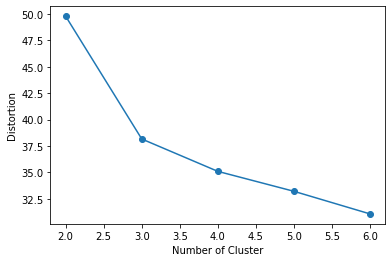

In [ ]:
plt.plot(range(2, 7), distortions, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.show()

* elbow point = 4

### 3-2. Clustering

In [ ]:
# 약 2분
%%time
model_dtw = TimeSeriesKMeans(n_clusters=3, init='random', n_init=10, max_iter=300, random_state=1234, metric = 'dtw').fit(buy_ts)

CPU times: user 2min 6s, sys: 1min 18s, total: 3min 24s
Wall time: 1min 59s


In [ ]:
result_dtw = model_dtw.predict(buy_ts)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 40 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [ ]:
buy_ts['cluster'] = result_dtw

In [ ]:
buy_ts.head(2)

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가스온수기,-0.403750,0.482756,-0.403750,-0.40375,-0.403750,-0.403750,0.482756,-0.403750,0.482756,0.482756,-0.40375,0.719709,-0.403750,1.369263,0.482756,1.606215,-0.403750,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,1.843168,0.482756,-0.403750,-0.403750,1.606215,-0.403750,-0.403750,-0.403750,0.719709,1.606215,1.369263,-0.403750,-0.40375,...,1.606215,-0.403750,0.482756,-0.40375,0.482756,0.482756,-0.403750,2.255769,0.719709,-0.403750,0.482756,-0.403750,-0.403750,0.482756,0.482756,-0.40375,0.482756,-0.403750,-0.403750,0.719709,0.482756,0.482756,-0.403750,2.966627,0.719709,0.719709,0.719709,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,0.482756,-0.403750,-0.40375,-0.40375,-0.403750,0
가열식 가습기,2.034589,1.327837,1.533372,1.41079,0.556221,1.201658,1.111509,1.320641,1.601883,0.970888,0.48771,0.372324,0.192026,0.329049,0.559819,0.119917,0.123515,0.119917,-0.251475,-0.017106,0.047807,0.325451,0.556221,0.549025,0.574261,-0.319986,0.206468,0.988927,0.689646,0.393962,0.073043,-0.114452,-0.345222,-0.139688,-0.143286,-0.301946,-0.182963,0.141554,0.300215,-0.27671,...,0.711283,1.151186,1.879527,1.65960,2.286997,1.454066,1.136745,0.729274,0.538181,2.085061,2.651143,2.135533,2.618711,4.115021,1.792976,2.17521,3.639137,3.372336,2.748537,2.467295,2.005755,1.169225,1.320641,2.589877,1.558656,1.273767,1.861487,1.479302,0.538181,1.259326,1.627119,1.158382,1.147588,1.136745,2.323076,0.924014,1.14399,1.18002,0.422796,1


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


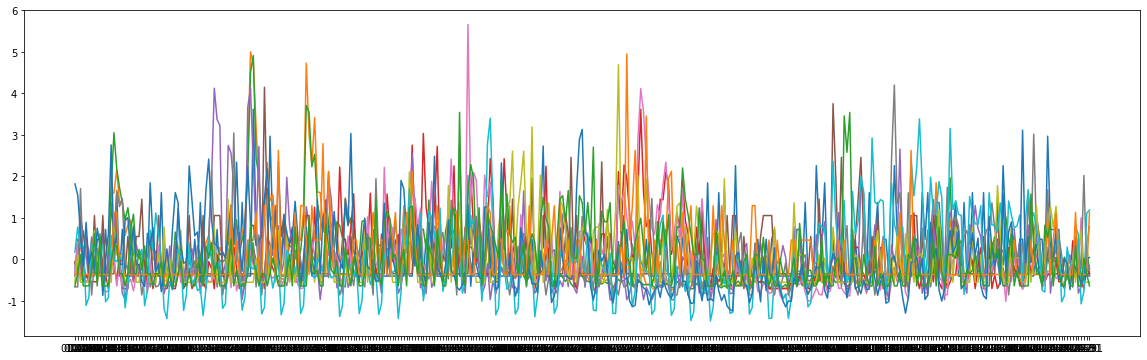

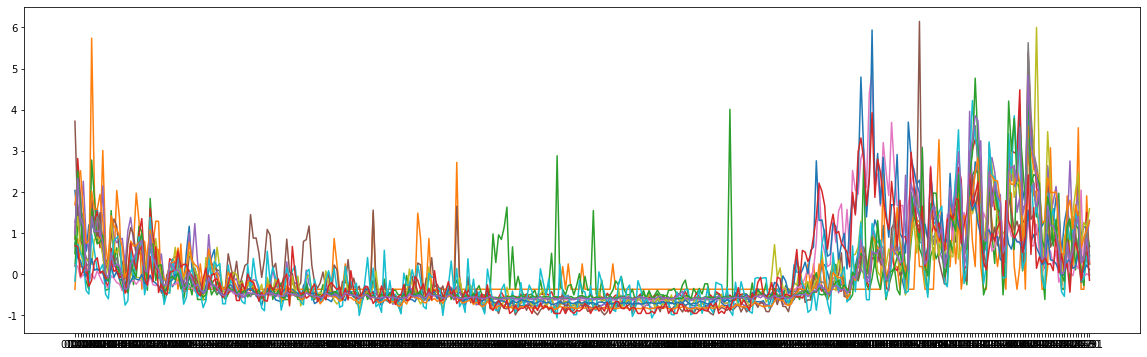

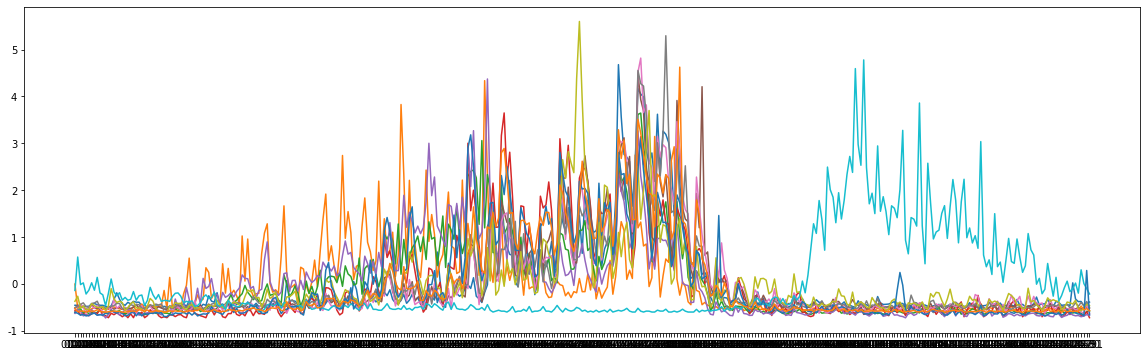

In [ ]:
for i in range(3):
    clusters = buy_ts[buy_ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

<function matplotlib.pyplot.show>

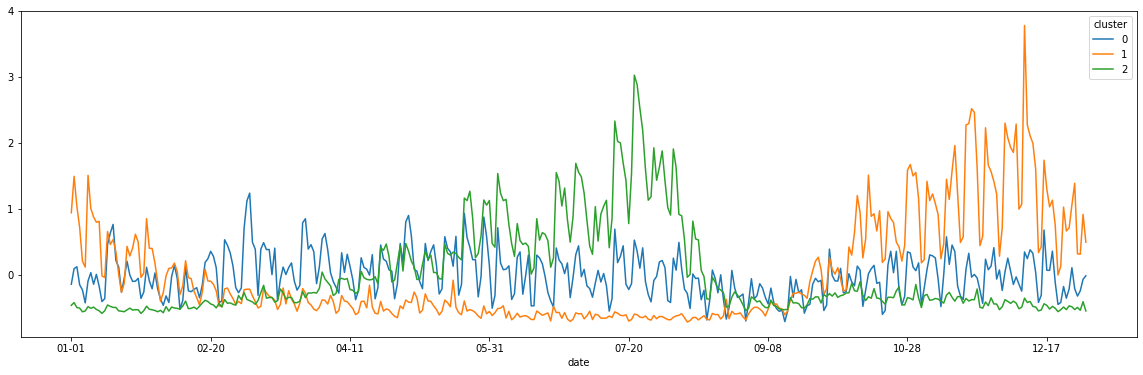

In [ ]:
plt.rcParams["figure.figsize"]=(20,6)
buy_ts.groupby(['cluster']).mean().T.plot()
plt.show

In [ ]:
data_final = buy_ts.reset_index()

In [ ]:
data_final.head(2)

date,sm_cat,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
0,가스온수기,-0.403750,0.482756,-0.403750,-0.40375,-0.403750,-0.403750,0.482756,-0.403750,0.482756,0.482756,-0.40375,0.719709,-0.403750,1.369263,0.482756,1.606215,-0.403750,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,1.843168,0.482756,-0.403750,-0.403750,1.606215,-0.403750,-0.403750,-0.403750,0.719709,1.606215,1.369263,-0.403750,...,1.606215,-0.403750,0.482756,-0.40375,0.482756,0.482756,-0.403750,2.255769,0.719709,-0.403750,0.482756,-0.403750,-0.403750,0.482756,0.482756,-0.40375,0.482756,-0.403750,-0.403750,0.719709,0.482756,0.482756,-0.403750,2.966627,0.719709,0.719709,0.719709,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,0.482756,-0.403750,-0.40375,-0.40375,-0.403750,0
1,가열식 가습기,2.034589,1.327837,1.533372,1.41079,0.556221,1.201658,1.111509,1.320641,1.601883,0.970888,0.48771,0.372324,0.192026,0.329049,0.559819,0.119917,0.123515,0.119917,-0.251475,-0.017106,0.047807,0.325451,0.556221,0.549025,0.574261,-0.319986,0.206468,0.988927,0.689646,0.393962,0.073043,-0.114452,-0.345222,-0.139688,-0.143286,-0.301946,-0.182963,0.141554,0.300215,...,0.711283,1.151186,1.879527,1.65960,2.286997,1.454066,1.136745,0.729274,0.538181,2.085061,2.651143,2.135533,2.618711,4.115021,1.792976,2.17521,3.639137,3.372336,2.748537,2.467295,2.005755,1.169225,1.320641,2.589877,1.558656,1.273767,1.861487,1.479302,0.538181,1.259326,1.627119,1.158382,1.147588,1.136745,2.323076,0.924014,1.14399,1.18002,0.422796,1


In [ ]:
data_final.to_csv('/content/drive/MyDrive/기상청/데이터/cluster_dtw_scaling.csv', encoding='CP949', index = False)

In [ ]:
# 확인
# pd.read_csv('/content/drive/MyDrive/기상청/데이터/cluster_dtw_scaling.csv', encoding='CP949')

In [ ]:
pd.set_option('display.max_rows', 2000)

In [ ]:
for i in range(3):
    print("클러스터",i)
    print("소분류 개수: ",data_final[data_final['cluster']==i]['sm_cat'].shape[0])
    print(data_final[data_final['cluster']==i]['sm_cat'])
    print('======='*10)

클러스터 0
소분류 개수:  13
0         가스온수기
2       공기정화 용품
3         공기청정기
10    벽걸이형 냉온풍기
12          보일러
14         산림욕기
15    스탠드형 냉온풍기
17        신발건조기
20         에어커튼
23         온열매트
25        의류건조기
31      중대형 에어컨
32      천장형 에어컨
Name: sm_cat, dtype: object
클러스터 1
소분류 개수:  15
1      가열식 가습기
4      난방용 열풍기
6          돈풍기
7        라디에이터
13     복합식 가습기
19        에어워셔
22        온수매트
24         온풍기
27     자연식 가습기
28       전기온수기
29        전기장판
33    초음파식 가습기
35         컨벡터
37        황토매트
39          히터
Name: sm_cat, dtype: object
클러스터 2
소분류 개수:  12
5            냉풍기
8        멀티형 에어컨
9        벽걸이 에어컨
11      벽걸이형 선풍기
16      스탠드형 에어컨
18       업소용 선풍기
21       에어컨 리모컨
26       이동형 에어컨
30           제습기
34         카페트매트
36    탁상/USB 선풍기
38       휴대용 선풍기
Name: sm_cat, dtype: object
